In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Initialize project paths
import sys
import os

# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

In [3]:
from scripts.data_load import *
from scripts.data_preprocessing import *

import numpy as np 
import pandas as pd
from dateutil.relativedelta import relativedelta
import hdbscan

from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from tqdm import tqdm
import pickle
import random

import networkx as nx

from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_columns', None)
pd.set_option("display.width", 1000)

## 0. Loading Data 

In [4]:
# Tables to load for provider graphs

preprocessed_datasets = {}
raw_datasets = {}

tables_to_load = {"tblproviders", "tblclaims", "tblmembers", "tblclaimdetails", "tblclaimdiagnosis",
                 "tblcpttable", "tblicdtable", "tblbenefitsa"}

for table in tables_to_load : 
    raw_datasets[table] = load_table(table)
    #preprocessed_datasets[table] = preprocess_data(raw_datasets[table], table)


In [6]:
def filter_claims(df):
    """Filter claims to include only settled claims in 2023."""
    df = df.loc[df["dateavailed"].dt.year == pd.Timestamp("2023").year]
    df = df.loc[df["claimstatus"] == "settled"]
    return df

def enrich_main_icd(df, tblicdtable):
    """Add main ICD codes to the claims data."""
    df = df.merge(tblicdtable[["icdno", "icdcode"]], how="left", on="icdno")
    df.dropna(subset=["icdcode"], inplace=True)
    df["main_icdcode"] = df["icdcode"]
    return df

def enrich_other_icds(df, tblclaimdiagnosis, tblicdtable):
    """Add secondary ICD codes and diseases to the claims data."""
    tblclaimdiagnosis = tblclaimdiagnosis.groupby("claimcode")[["icdno", "diagnosistype"]].agg(list).reset_index()
    tblclaimdiagnosis = tblclaimdiagnosis.explode("icdno")
    tblclaimdiagnosis = tblclaimdiagnosis.merge(tblicdtable[["icdno", "icdcode", "icddisease"]], how="left", on="icdno")
    tblclaimdiagnosis = tblclaimdiagnosis.groupby("claimcode").agg({
        "icdcode": list,
        "diagnosistype": list,
        "icddisease": lambda x: list(set(x))
    }).reset_index()
    df = df.merge(tblclaimdiagnosis, how="left", on="claimcode")
    df["icdcode_x"] = df["icdcode_x"].apply(lambda x : [x])
    df["icdcode"] = df["icdcode_x"] + df["icdcode_y"]
    #df["icdcode"] = df[["icdcode_x", "icdcode_y"]].apply(lambda x: x[0] + x[1] if x[1] else x[0], axis=1)
    df.drop(columns=["icdcode_x", "icdcode_y"], inplace=True)
    return df

def process_icd_codes(df):
    """Keep only root ICD codes and aggregate them by claim."""
    df = df.explode("icdcode")
    df.dropna(subset=["icdcode"], inplace=True)
    df["icdcode"] = df["icdcode"].apply(lambda x: x[:3])
    df_claimcode_icds = df.groupby("claimcode")["icdcode"].agg(lambda x: list(set(x))).reset_index()
    df = df.merge(df_claimcode_icds, how="left", on="claimcode", suffixes=("_initial", ""))
    df.drop(columns=["icdcode_initial"], inplace=True)
    return df

def enrich_cpt_and_benefits(df, tblclaimdetails, tblcpttable, tblbenefitsa):
    """Add CPT and benefit codes to the claims data."""
    tblclaimdetails = tblclaimdetails.groupby("caseno")[["cptno", "sacode"]].agg(list).reset_index()
    tblclaimdetails_cpts = tblclaimdetails.explode("cptno")
    tblclaimdetails_sacodes = tblclaimdetails.explode("sacode")

    tblclaimdetails_cpts = tblclaimdetails_cpts.merge(tblcpttable[["cptno", "cptcode", "cptsection", "cptsubsection", "descriptionlong"]], how="left", on="cptno")
    tblclaimdetails_sacodes = tblclaimdetails_sacodes.merge(tblbenefitsa[["sacode", "benefitcode", "benefit_description"]], how="left", on="sacode")

    tblclaimdetails_cpts["cptcode"].fillna("nocpt", inplace=True)
    tblclaimdetails_cpts["cptsubsection"] = tblclaimdetails_cpts.apply(
        lambda row: "nocpt" if row["cptcode"] == "nocpt" else row["cptsubsection"], axis=1
    )

    tblclaimdetails_cpts = tblclaimdetails_cpts.groupby("caseno")[["cptcode", "cptsubsection", "descriptionlong"]].agg(lambda x: list(set(x))).reset_index()
    tblclaimdetails_sacodes = tblclaimdetails_sacodes.groupby("caseno")[["benefitcode", "benefit_description"]].agg(lambda x: list(set(x))).reset_index()

    df = df.merge(tblclaimdetails_cpts, how="left", on="caseno")
    df = df.merge(tblclaimdetails_sacodes, how="left", on="caseno")
    df.rename(columns={"cptsubsection": "cptcode_subsection", "descriptionlong": "cpt_description"}, inplace=True)
    return df

def enrich_member_info(df, tblmembers):
    """Add member demographic information to the claims data."""
    tblmembers = tblmembers[tblmembers["gender"] != ""]
    tblmembers["principalcode"] = np.where(tblmembers["principalcode"] != 0, "dependant", "principal")
    df = df.merge(tblmembers, how="left", on="membercode")
    df["member_age"] = (df["dateavailed"] - df["birthdate"]).dt.days // 365
    df.dropna(subset=["member_age"], inplace=True)
    return df

def preprocess_claims(raw_datasets):
    """Main function to preprocess claims data and enrich with external data."""
    df = preprocess_data(raw_datasets["tblclaims"].copy(), "tblclaims")
    df = filter_claims(df)

    # Enrich data
    tblicdtable = preprocess_data(raw_datasets["tblicdtable"], "tblicdtable")
    df = enrich_main_icd(df, tblicdtable)

    tblclaimdiagnosis = preprocess_data(raw_datasets["tblclaimdiagnosis"], "tblclaimdiagnosis")
    df = enrich_other_icds(df, tblclaimdiagnosis, tblicdtable)
    df = process_icd_codes(df)

    tblclaimdetails = preprocess_data(raw_datasets["tblclaimdetails"], "tblclaimdetails")
    tblcpttable = preprocess_data(raw_datasets["tblcpttable"], "tblcpttable")
    tblbenefitsa = preprocess_data(raw_datasets["tblbenefitsa"], "tblbenefitsa")
    tblbenefitsa.rename(columns={"description": "benefit_description"}, inplace=True)
    df = enrich_cpt_and_benefits(df, tblclaimdetails, tblcpttable, tblbenefitsa)

    tblmembers = preprocess_data(raw_datasets["tblmembers"], "tblmembers")
    df = enrich_member_info(df, tblmembers)

    return df

# Call the main function
#df_bis = preprocess_claims(raw_datasets)

In [36]:
len(df)

170665

In [6]:
df = raw_datasets["tblclaims"].copy()
df = preprocess_data(df, "tblclaims")

# keep only claims in 2023
df = df.loc[df["dateavailed"].dt.year == pd.Timestamp("2023").year]
# Keep only claims that were settled 
df = df.loc[df["claimstatus"]=="settled"]

# Get associated main icd 
tblicdtable = preprocess_data(raw_datasets["tblicdtable"], "tblicdtable")
df = df.merge(tblicdtable[["icdno", "icdcode"]], how="left", on="icdno")
df.dropna(subset="icdcode", inplace=True)
df["main_icdcode"] = df["icdcode"]

# Get other icds 
tblclaimdiagnosis = preprocess_data(raw_datasets["tblclaimdiagnosis"], "tblclaimdiagnosis")
tblclaimdiagnosis = tblclaimdiagnosis.groupby("claimcode")[["icdno", "diagnosistype"]].agg(list).reset_index()
tblclaimdiagnosis = tblclaimdiagnosis.explode("icdno")
tblicdtable = preprocess_data(raw_datasets["tblicdtable"], "tblicdtable")
tblclaimdiagnosis = tblclaimdiagnosis.merge(tblicdtable[["icdno", "icdcode", "icddisease"]], how="left", on="icdno")
tblclaimdiagnosis = tblclaimdiagnosis.groupby("claimcode").agg({
    "icdcode": list,
    "diagnosistype": list,
    "icddisease": lambda x: list(set(x))  # Convert to set, then back to list
}).reset_index()
df = df.merge(tblclaimdiagnosis[["claimcode", "icdcode", "icddisease"]], how="left", on="claimcode")
df["icdcode_x"] = df["icdcode_x"].apply(lambda x : [x])
df["icdcode"] = df["icdcode_x"] + df["icdcode_y"]
df.drop(columns=["icdcode_x","icdcode_y"], inplace=True)

## Keep only root icd code 
df = df.explode("icdcode")
## Drop lines without icd
df.dropna(subset="icdcode", inplace=True)
## Keep only root icd code 
df["icdcode"] = df["icdcode"].apply(lambda x : x[:3])
## Regroup list of icds :
df_claimcode_icds = df[["claimcode", "icdcode"]].copy()
df_claimcode_icds = df_claimcode_icds.groupby("claimcode").icdcode.agg(lambda x : list(set(x))).reset_index()
df = df.merge(df_claimcode_icds, how="left", on="claimcode", suffixes=('_initial', '')) 
df.drop_duplicates("claimcode", inplace=True)
df.drop(columns="icdcode_initial", inplace=True)

# Get associated list of cpts and benefits
tblclaimdetails = preprocess_data(raw_datasets["tblclaimdetails"], "tblclaimdetails")
tblclaimdetails = tblclaimdetails.groupby("caseno")[["cptno", "sacode"]].agg(list).reset_index()
tblclaimdetails_cpts = tblclaimdetails.explode("cptno")
tblclaimdetails_sacodes = tblclaimdetails.explode("sacode")

tblcpttable = preprocess_data(raw_datasets["tblcpttable"], "tblcpttable")
tblbenefitsa = preprocess_data(raw_datasets["tblbenefitsa"], "tblbenefitsa")
tblbenefitsa.rename(columns={"description" : "benefit_description"}, inplace=True)

tblclaimdetails_cpts = tblclaimdetails_cpts.merge(tblcpttable[["cptno", "cptcode","cptsection", "cptsubsection", "descriptionlong"]], how="left", on="cptno")
tblclaimdetails_sacodes = tblclaimdetails_sacodes.merge(tblbenefitsa[["sacode", "benefitcode","benefit_description"]], how="left", on="sacode")

tblclaimdetails_cpts = tblclaimdetails_cpts[tblclaimdetails_cpts.cptsubsection != ""]
tblclaimdetails_cpts["cptcode"].fillna("nocpt", inplace=True)
tblclaimdetails_cpts["cptsubsection"] = np.where(tblclaimdetails_cpts["cptcode"] == "nocpt", "nocpt", tblclaimdetails_cpts["cptsubsection"])

tblclaimdetails_cpts = tblclaimdetails_cpts.groupby("caseno")[["cptcode", "cptsubsection", "descriptionlong"]].agg(lambda x : list(set(x))).reset_index()
tblclaimdetails_sacodes = tblclaimdetails_sacodes.groupby("caseno")[["benefitcode", "benefit_description"]].agg(lambda x : list(set(x))).reset_index()

df = df.merge(tblclaimdetails_cpts[["caseno", "cptcode", "cptsubsection", "descriptionlong"]], how="left", on="caseno")
df.drop_duplicates("claimcode", inplace=True)
df.rename(columns={"cptsubsection" : "cptcode_subsection", "descriptionlong" : 'cpt_description'}, inplace=True)

df = df.merge(tblclaimdetails_sacodes[["caseno", "benefitcode", "benefit_description"]], how="left", on="caseno")
df.drop_duplicates("claimcode", inplace=True)
df.dropna(subset="cptcode", inplace=True)

# Add info about the members
tblmembers = preprocess_data(raw_datasets["tblmembers"], "tblmembers")
tblmembers = tblmembers.loc[tblmembers["gender"]!=""]
tblmembers["principalcode"] = np.where(
    tblmembers["principalcode"] != 0,
    "dependant",
    "principal"
)

df = df.merge(tblmembers, how="left", on="membercode")
df["member_age"] = (df["dateavailed"] - df["birthdate"]).dt.days // 365
df.dropna(subset="member_age", inplace=True)

In [4]:
#with open("df_descriptions.pickle", 'wb') as pickle_file : 
    #pickle.dump(df,pickle_file)

with open("df_descriptions.pickle", 'rb') as pickle_file : 
    df = pickle.load(pickle_file)

In [7]:
df.columns

Index(['casetype', 'roomtype', 'finalstatus', 'claimtype', 'icdno', 'loastatus', 'dateavailed', 'membercode', 'claimstatus', 'finalamount', 'caseno', 'classorder', 'providercode', 'claimcode', 'main_icdcode', 'icddisease', 'icdcode', 'cptcode', 'cptcode_subsection', 'cpt_description', 'benefitcode', 'benefit_description', 'birthdate', 'principalcode', 'gender', 'member_age'], dtype='object')

## 1. Feature extraction 

In [8]:
def compute_period_between_claims(group):
    group = group.sort_values('dateavailed')
    group['claim_period'] = group['dateavailed'].diff().dt.days
    return group


def compute_tfidf_custom(df, index_column, columns_to_transform, regroup_vectors=False):
    """
    Compute TF-IDF vectors for specified columns in a DataFrame using a custom method.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        index_column (str): Column to use as index.
        columns_to_transform (list): List of columns containing lists to compute TF-IDF.
        regroup_vectors (bool): If True, combine all TF-IDF values for each column into a single list column.

    Returns:
        pd.DataFrame: DataFrame with the index column and TF-IDF vectors for each transformed column.
    """
    result_df = df[[index_column]].copy()

    for col in tqdm(columns_to_transform):
        vocabulary = sorted(set(term for terms in df[col] for term in terms))
        term_document_matrix = pd.DataFrame(0, index=df[index_column], columns=vocabulary)
        for i, row in df.iterrows():
            terms = row[col]
            term_counts = pd.Series(terms).value_counts()
            term_document_matrix.loc[row[index_column], term_counts.index] = term_counts
        tf = term_document_matrix.div(term_document_matrix.sum(axis=1), axis=0)

        n_docs = len(df)
        idf = np.log(n_docs / (term_document_matrix > 0).sum(axis=0))

        tfidf = tf.multiply(idf)
        
        if regroup_vectors:
            result_df[f"{col}_tfidf_vector"] = tfidf.apply(lambda x: x.tolist(), axis=1)
        else:
            tfidf.columns = [f"{col}_{term}" for term in tfidf.columns]
            tfidf = tfidf.reset_index()
            result_df = result_df.merge(tfidf, on=index_column, how="left")
    
    return result_df

# Function to compute embedding for a single text
def get_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token embedding (first token) as the sentence embedding
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

def get_semantic_feature(df, columns, model_name="bert-base-uncased"):
    """
    Computes the embedded representation for specified columns in a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        columns (list): List of column names to process.
        model_name (str): Name of the pre-trained model to use for embeddings.

    Returns:
        pd.DataFrame: DataFrame with embeddings for each specified column.
    """
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Create a new DataFrame to store embeddings
    result_df = df.copy()

    # Iterate over the columns to compute embeddings
    for col in columns:
        # Concatenate strings in the list for each row
        result_df[f"{col}_embedding"] = result_df[col].apply(lambda x: " ".join(x))
        # Compute embeddings for the joined strings
        result_df[f"{col}_embedding"] = result_df[f"{col}_embedding"].apply(
            lambda x: get_embedding(x, tokenizer, model)
        )

    return result_df



#### 1.1. Provider features

In [37]:
# Provider features : 
tblproviders = preprocess_data(raw_datasets["tblproviders"], "tblproviders")

# TF-IDF features 

#tfidf_columns_provider = ["icdcode", "main_icdcode", "cptcode_subsection", "benefitcode"]
#df.main_icdcode = df.main_icdcode.apply(lambda x : [x])
#aggregation = {col: lambda x: sum(x, []) for col in tfidf_columns_provider}

#grouped_df = df.groupby("providercode").agg(aggregation).reset_index()
#df_provider_features_tf_idf = compute_tfidf_custom(grouped_df, "providercode", tfidf_columns_provider, regroup_vectors=False)
#df_provider_features = df_provider_features.merge(df_provider_features_tf_idf, how="left", on="providercode")

2025-01-15 14:13:43,345 - Dropping columns with more than 50.0% missing values: ['contractexpiry', 'contracteffectivity', 'latitude', 'longitude']


In [9]:
numerical_feature_descriptions = {
    # Claim Frequency & Visit Density Features
    'mean_member_claim_period': "The mean of member-level claim periods aggregated by provider.",
    'median_member_claim_period': "The median of member-level claim periods aggregated by provider.",
    'min_member_claim_period': "The minimum of member-level claim periods aggregated by provider.",
    'max_member_claim_period': "The maximum of member-level claim periods aggregated by provider.",
    'std_member_claim_period': "The standard deviation of member-level claim periods aggregated by provider.",
    'mean_claim_period': "The mean of claim periods directly aggregated by provider.",
    'median_claim_period': "The median of claim periods directly aggregated by provider.",
    'min_claim_period': "The minimum of claim periods directly aggregated by provider.",
    'max_claim_period': "The maximum of claim periods directly aggregated by provider.",
    'std_claim_period': "The standard deviation of claim periods directly aggregated by provider.",
    
    # Claim Amount Features
    'mean_member_claim_amount': "The mean of member-level claim amounts aggregated by provider.",
    'median_member_claim_amount': "The median of member-level claim amounts aggregated by provider.",
    'min_member_claim_amount': "The minimum of member-level claim amounts aggregated by provider.",
    'max_member_claim_amount': "The maximum of member-level claim amounts aggregated by provider.",
    'std_member_claim_amount': "The standard deviation of member-level claim amounts aggregated by provider.",
    'mean_claim_amount': "The mean of claim amounts directly aggregated by provider.",
    'median_claim_amount': "The median of claim amounts directly aggregated by provider.",
    'min_claim_amount': "The minimum of claim amounts directly aggregated by provider.",
    'max_claim_amount': "The maximum of claim amounts directly aggregated by provider.",
    'std_claim_amount': "The standard deviation of claim amounts directly aggregated by provider.",
    
    # Other Features
    'single_interaction_ratio': "The ratio of provider-member interactions that consist of only one interaction.",
    'num_members': "The number of unique members associated with each provider.",
    'num_claims': "The total number of unique claims submitted by each provider."
}


In [22]:
# Feature Extraction 

# Get list of providers to keep (at least 10 members)
count_interactions = df.groupby('providercode').agg(num_members=('membercode', 'nunique')).reset_index()
providers_to_keep = count_interactions[count_interactions.num_members>=10].providercode.to_list()


## Numerical features ##
numerical_features = df.copy()
numerical_features['dateavailed'] = pd.to_datetime(numerical_features['dateavailed'])
numerical_features = numerical_features[numerical_features.providercode.isin(providers_to_keep)]

# Claim Frequency Features
## Compute claim periods per provider-member pair
numerical_features = numerical_features.groupby(['providercode', 'membercode']).apply(compute_period_between_claims)
numerical_features.reset_index(drop=True, inplace=True)
## Aggregate claim periods per provider-member pair
provider_member_frequency = numerical_features.groupby(['providercode', 'membercode']).agg(
    mean_claim_period=('claim_period', 'mean'),
    median_claim_period=('claim_period', 'median'),
    min_claim_period=('claim_period', 'min'),
    max_claim_period=('claim_period', 'max'),
    std_claim_period=('claim_period', 'std')
)
## Aggregate member-level statistics per provider
provider_frequency_agg = provider_member_frequency.groupby('providercode').agg(
    mean_member_claim_period=('mean_claim_period', 'mean'),
    median_member_claim_period=('median_claim_period', 'mean'),
    min_member_claim_period=('min_claim_period', 'mean'),
    max_member_claim_period=('max_claim_period', 'mean'),
    std_member_claim_period=('std_claim_period', 'mean')
)
## Direct provider-level claim frequency statistics
direct_provider_frequency = numerical_features.groupby('providercode').agg(
    mean_claim_period=('claim_period', 'mean'),
    median_claim_period=('claim_period', 'median'),
    min_claim_period=('claim_period', 'min'),
    max_claim_period=('claim_period', 'max'),
    std_claim_period=('claim_period', 'std')
)

# Claim Amount Features
## Aggregate claim amounts per provider-member pair
provider_member_amounts = numerical_features.groupby(['providercode', 'membercode']).agg(
    mean_claim_amount=('finalamount', 'mean'),
    median_claim_amount=('finalamount', 'median'),
    min_claim_amount=('finalamount', 'min'),
    max_claim_amount=('finalamount', 'max'),
    std_claim_amount=('finalamount', 'std')
)
## Aggregate member-level claim amounts per provider
provider_amount_agg = provider_member_amounts.groupby('providercode').agg(
    mean_member_claim_amount=('mean_claim_amount', 'mean'),
    median_member_claim_amount=('median_claim_amount', 'mean'),
    min_member_claim_amount=('min_claim_amount', 'mean'),
    max_member_claim_amount=('max_claim_amount', 'mean'),
    std_member_claim_amount=('std_claim_amount', 'mean')
)
## Direct provider-level claim amount statistics
direct_provider_amounts = numerical_features.groupby('providercode').agg(
    mean_claim_amount=('finalamount', 'mean'),
    median_claim_amount=('finalamount', 'median'),
    min_claim_amount=('finalamount', 'min'),
    max_claim_amount=('finalamount', 'max'),
    std_claim_amount=('finalamount', 'std')
)

# Other Features
## Single interaction ratios
numerical_features['single_interaction_flag'] = numerical_features.groupby(['providercode', 'membercode'])['dateavailed'].transform('count') == 1
single_interaction_ratio = numerical_features.groupby('providercode').agg(
    single_interaction_ratio=('single_interaction_flag', 'mean')
)

## Number of members and claims per provider
members_per_provider = numerical_features.groupby('providercode').agg(
    num_members=('membercode', 'nunique')
)
claims_per_provider = numerical_features.groupby('providercode').agg(
    num_claims=('claimcode', 'nunique')
)

# Combine all numerical features
final_features = pd.concat([
    provider_frequency_agg,
    direct_provider_frequency,
    provider_amount_agg,
    direct_provider_amounts,
    single_interaction_ratio,
    members_per_provider,
    claims_per_provider
], axis=1)
final_features.reset_index(inplace=True)

# Preprocessing Pipeline
log_transform = FunctionTransformer(func=lambda x: np.log1p(x), inverse_func=lambda x: np.expm1(x), validate=True)
class CustomImputer(SimpleImputer):
    def inverse_transform(self, X):
        return X

preprocessing_pipeline = Pipeline(steps=[
    ("impute", CustomImputer(strategy="median")),
    ("log_transform", log_transform),
    ("scale", RobustScaler())
])

processed_features = preprocessing_pipeline.fit_transform(final_features.drop(columns=['providercode']))
reverted_features = preprocessing_pipeline.inverse_transform(processed_features)

processed_df = pd.DataFrame(
    processed_features, 
    columns=final_features.drop(columns=['providercode']).columns, 
    index=final_features['providercode']
)
reverted_df = pd.DataFrame(
    reverted_features, 
    columns=final_features.drop(columns=['providercode']).columns, 
    index=final_features['providercode']
)

## Categorical features ##
tblproviders = preprocess_data(raw_datasets["tblproviders"], "tblproviders")
tblproviders = tblproviders[tblproviders.providercode.isin(providers_to_keep)]

provider_specific_columns = ["providertype", "providerlevel", "accredited"]
#provider_specific_columns = ["providertype", "regcode", "providerlevel", "accredited"]

provider_encoder = ColumnTransformer(
    transformers=[
        ("one_hot_provider", OneHotEncoder(drop="if_binary", sparse_output=False, min_frequency=50), provider_specific_columns)
    ],
    remainder="drop"
)

provider_features_array = provider_encoder.fit_transform(tblproviders)
provider_features_df = pd.DataFrame(
    provider_features_array, 
    columns=provider_encoder.get_feature_names_out(), 
    index=tblproviders.index
)
provider_features = tblproviders.drop(columns=provider_specific_columns).join(provider_features_df)

claim_based_columns = ['finalstatus', 'claimtype', 'loastatus', 'roomtype', 'claimstatus', "principalcode", "casetype", "gender"]
claim_encoder = ColumnTransformer(
    transformers=[
        ("one_hot_claim", OneHotEncoder(drop="first", sparse_output=False, min_frequency=0.1), claim_based_columns)
    ],
    remainder="drop"
)
df_categ = df.copy() 
df_categ = df_categ[df_categ.providercode.isin(providers_to_keep)]
claim_features_array = claim_encoder.fit_transform(df_categ)
claim_features_df = pd.DataFrame(
    claim_features_array, 
    columns=claim_encoder.get_feature_names_out(), 
    index=df_categ.index
)
claim_features_df['providercode'] = df_categ['providercode']
claim_aggregated_features = claim_features_df.groupby('providercode').mean()

provider_features.drop(columns="citycode", inplace=True)
df_provider_features = claim_aggregated_features.merge(provider_features, how="left", left_on="providercode", right_on="providercode")
df_provider_features.drop(columns=["providername"], inplace=True)
#df_provider_features.drop(columns=["providername", "regcode"], inplace=True)
df_provider_features.index = df_provider_features.providercode
df_provider_features.drop(columns="providercode", inplace=True)
df_provider_features = df_provider_features.join(processed_df)

## Semantic features ##
df_semantic = df.copy() 
df_semantic = df_semantic[df_semantic.providercode.isin(providers_to_keep)]

semantics_columns_provider = ["icddisease", "cpt_description", "benefit_description"]
aggregation = {
    col: lambda lists: sorted(
        set.union(*(set(filter(lambda x: not (pd.isna(x) or x is None), lst)) for lst in lists)), 
        key=lambda x: float(hash(x))
    )
    for col in semantics_columns_provider
}
grouped_df_semantic = df_semantic.groupby("providercode").agg(aggregation).reset_index()
semantic_df = get_semantic_feature(grouped_df_semantic, semantics_columns_provider, model_name="bert-base-uncased")

icddisease_embeddings = np.stack(semantic_df["icddisease_embedding"].to_numpy())
cpt_description_embeddings = np.stack(semantic_df["cpt_description_embedding"].to_numpy())
benefit_description_embeddings = np.stack(semantic_df["benefit_description_embedding"].to_numpy())

semantic_df["initial_semantic_embedding"] = list(np.concatenate(
    [icddisease_embeddings, cpt_description_embeddings, benefit_description_embeddings],
    axis=1  
))
concatenated_embeddings = np.stack(semantic_df["initial_semantic_embedding"].to_numpy())

umap_reducer_semantic = umap.UMAP(n_components=2, random_state=42, metric='cosine')
umap_result_semantic = umap_reducer_semantic.fit_transform(concatenated_embeddings)

hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10, metric='euclidean', cluster_selection_method='eom')
hdbscan_labels = hdbscan_clusterer.fit_predict(umap_result_semantic)

semantic_df["hdbscan_cluster_from_semantics"] = hdbscan_labels.reshape(-1,1)
semantic_df = semantic_df.set_index("providercode")
df_provider_features = df_provider_features.join(semantic_df["hdbscan_cluster_from_semantics"])

final_df = df_provider_features.copy()

# Feature names
numerical_features = processed_df.columns.to_list()
categorical_features = pd.Series(final_df.columns)
categorical_features = categorical_features.loc[categorical_features.str.startswith("one")].to_list()
semantic_features = ["hdbscan_cluster_from_semantics"]



In [10]:
with open("final_df.pickle", "rb") as pickle_file : 
    providers_df = pickle.load(pickle_file)

In [11]:
providers_df

,one_hot_claim__finalstatus_infrequent_sklearn,one_hot_claim__claimtype_infrequent_sklearn,one_hot_claim__loastatus_infrequent_sklearn,one_hot_claim__roomtype_infrequent_sklearn,one_hot_claim__principalcode_principal,one_hot_claim__casetype_reimbursement,one_hot_claim__gender_m,one_hot_provider__providertype_clinic,one_hot_provider__providertype_hospital,one_hot_provider__providertype_infrequent_sklearn,one_hot_provider__providerlevel_level0,one_hot_provider__providerlevel_level1,one_hot_provider__providerlevel_level2,one_hot_provider__accredited_infrequent_sklearn,mean_member_claim_period,median_member_claim_period,min_member_claim_period,max_member_claim_period,std_member_claim_period,mean_claim_period,median_claim_period,min_claim_period,max_claim_period,std_claim_period,mean_member_claim_amount,median_member_claim_amount,min_member_claim_amount,max_member_claim_amount,std_member_claim_amount,mean_claim_amount,median_claim_amount,min_claim_amount,max_claim_amount,std_claim_amount,single_interaction_ratio,num_members,num_claims,hdbscan_cluster_from_semantics
providercode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.062780,0.008969,0.0,0.349776,0.067265,0.399103,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.124769,-0.080504,-0.185405,-0.094656,0.079513,-0.064445,-0.429308,0.0,0.027869,-0.038447,0.134638,0.005079,0.029332,0.501533,0.524022,0.321360,0.050260,-0.262126,0.966920,0.789321,-0.449752,0.563258,0.548708,1
17,0.0,0.000000,0.000000,0.0,0.472222,0.083333,0.333333,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.124695,0.244329,0.339322,-0.255670,0.137365,0.209892,0.000000,0.0,-0.833797,-0.132497,0.308787,0.309342,0.334307,0.189355,0.537356,0.474466,0.675916,0.763060,-0.215126,-0.003480,1.110301,-0.277891,-0.568451,1
53,0.0,0.008342,0.005214,0.0,0.662148,0.020855,0.344108,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.412900,-0.415572,-0.510820,-0.210853,-0.211600,-0.474252,-0.193043,0.0,0.728740,-0.456984,-0.603881,-0.739750,-0.645090,-0.370478,-0.393823,-0.617874,-0.583296,-0.231640,0.285726,-0.109757,-0.722677,1.375164,1.451557,1
54,0.0,0.007160,0.004773,0.0,0.625298,0.026253,0.436754,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.680374,-0.593849,-0.913887,-0.460248,-0.184329,-0.569375,-0.733907,0.0,0.270935,-0.409968,-0.442921,-0.527858,-0.465632,-0.335042,-0.328537,-0.548802,-0.583296,-0.440637,0.323048,-0.065129,-0.578037,0.911511,0.938692,1
76,0.0,0.175573,0.000000,0.0,0.694656,0.045802,0.580153,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.180179,1.071630,1.179376,1.032700,1.140953,0.996536,-0.429308,0.0,0.516334,1.141439,1.013815,0.995648,0.982742,0.931602,0.851399,1.081335,0.571845,0.456543,0.548513,0.721966,0.413834,0.404467,0.220617,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7525,0.0,0.000000,0.000000,0.0,0.880000,0.000000,0.260000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.657182,-0.432147,-0.906828,-0.725141,-0.143283,-0.877799,-1.897123,0.0,0.120731,0.007727,-0.365236,-0.488039,-0.563108,-0.169762,0.196842,-0.318569,-0.583296,-0.125349,-0.363876,-0.182183,-0.221851,-0.353372,-0.369362,1
7550,0.0,0.000000,0.000000,0.0,0.500000,0.041667,0.479167,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.706299,-0.920926,-0.502804,-0.569707,0.284618,-0.353005,-0.733907,0.0,-0.231897,0.000032,-0.636190,-0.664088,-0.748920,-0.624728,-0.436999,-0.660346,-0.583296,0.591290,-0.382813,-0.385077,-0.476042,-0.353372,-0.394181,1
7551,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.884615,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-2.550465,-2.004333,-2.191401,-3.048707,-1.990775,-2.618035,-1.897123,0.0,-3.029534,-3.380130,-1.348694,-1.363922,-1.168016,-1.483251,-1.423644,-1.465901,-0.583296,0.110652,-0.780312,-0.973475,0.260782,-0.610238,-0.763925,1


#### 1.2 Patient features

In [28]:
# Patient features 

def compute_period_between_claims(group):
    group = group.sort_values('dateavailed')
    group['claim_period'] = group['dateavailed'].diff().dt.days
    return group

def compute_member_features(df):
    """Compute numerical and categorical features for each member."""
    # Numerical Features
    df['dateavailed'] = pd.to_datetime(df['dateavailed'])
    # Number of claims per member (keep only members with at least 2 claims)
    
    # Number of distinct providers per member 
    # Claim Periods per member
    member_claim_frequency = df.groupby(['membercode']).apply(compute_period_between_claims)
    member_claim_frequency.reset_index(drop=True, inplace=True)

    member_frequency_agg = member_claim_frequency.groupby('membercode').agg(
        mean_member_claim_period=('claim_period', 'mean'),
        median_member_claim_period=('claim_period', 'median'),
        min_member_claim_period=('claim_period', 'min'),
        max_member_claim_period=('claim_period', 'max'),
        std_member_claim_period=('claim_period', 'std')
    )
    # Claim Periods per member per provider
    # 
    # 

    # Merge numercial features dfs
    frequency_features = pd.concat([
        member_frequency_agg,
        
    ], axis=1)

    # Categorical Features
    categorical_features = df.groupby("membercode").agg({
        "gender": "first",
        "principalcode": "first",
        "roomtype": lambda x: x.mode()[0] if not x.mode().empty else None,
        "claimtype": lambda x: x.mode()[0] if not x.mode().empty else None
    }).reset_index()

    # Merge all features
    member_features = frequency_features.reset_index().merge(categorical_features, on="membercode")

    return member_features

#members_df = compute_member_features(df)

In [51]:
# Feature Extraction for Members 

# 1. Initial Filtering (Members with ≥2 claims)
member_claims = df.groupby('membercode').agg(num_claims=('claimcode', 'count')).reset_index()
members_to_keep = member_claims[member_claims.num_claims >= 2].membercode.to_list()
filtered_df = df[df.membercode.isin(members_to_keep)].copy()

In [52]:
# 2. Process Categorical Features --------------------------------------------------------------
# Mode-based categorical features (constant per member)
mode_categorical = filtered_df.groupby("membercode").agg({
    "gender": lambda x: x.mode()[0] if not x.mode().empty else 'missing',
    "principalcode": lambda x: x.mode()[0] if not x.mode().empty else 'missing'
})

In [33]:
mode_categorical

,gender,principalcode
membercode,,
589143,f,principal
589150,f,principal
589151,m,dependant
589152,m,dependant
589154,m,principal
...,...,...
8782694,f,principal
8804580,m,principal
8804581,m,principal


In [53]:
# Proportional categorical features (vary per claim)
# Create dummy columns first
#roomtype_dummies = pd.get_dummies(filtered_df['roomtype'], prefix='roomtype')
claimtype_dummies = pd.get_dummies(filtered_df['claimtype'], prefix='claimtype')

# Calculate proportions per member
#proportional_features = pd.concat([
    #roomtype_dummies.groupby(filtered_df['membercode']).mean().add_prefix('prop_'),
    #claimtype_dummies.groupby(filtered_df['membercode']).mean().add_prefix('prop_')
#], axis=1).fillna(0)

In [54]:
proportional_features  = claimtype_dummies.groupby(filtered_df['membercode']).mean().add_prefix('prop_')
proportional_features["prop_claimtype_not_op"] = proportional_features.iloc[:, :5].sum(axis=1)
proportional_features = proportional_features.drop(proportional_features.columns[:5], axis=1)


In [50]:
(proportional_features.prop_claimtype_not_op==0).sum()

np.int64(25996)

In [62]:
# 3. Process Temporal Features -----------------------------------------------------------------
filtered_df['dateavailed'] = pd.to_datetime(filtered_df['dateavailed'])

# Compute claim periods per member-provider pair
numerical_features = filtered_df.groupby(['membercode', 'providercode'])\
                                .apply(compute_period_between_claims)\
                                .reset_index(drop=True)

# 4. Feature Engineering Steps -----------------------------------------------------------------
# Member-Provider Pair Features
member_provider_agg = numerical_features.groupby(['membercode', 'providercode']).agg(
    mp_mean_claim_period=('claim_period', 'mean'),
    mp_median_claim_period=('claim_period', 'median'),
    mp_mean_claim_amount=('finalamount', 'mean'),
    mp_max_claim_amount=('finalamount', 'max'),
    mp_claim_count=('claimcode', 'count')
).reset_index()

# Aggregate Provider-level stats to Member-level
member_from_providers = member_provider_agg.groupby('membercode').agg(
    avg_provider_claim_period=('mp_mean_claim_period', 'mean'),
    std_provider_claim_period=('mp_mean_claim_period', 'std'),
    max_provider_claim_amount=('mp_max_claim_amount', 'max'),
    avg_provider_claim_amount=('mp_mean_claim_amount', 'mean'),
    unique_providers=('providercode', 'nunique')
)

# Core Member-level Features
member_frequency_agg = numerical_features.groupby('membercode').agg(
    mean_claim_period=('claim_period', 'mean'),
    median_claim_period=('claim_period', 'median'),
    min_claim_period=('claim_period', 'min'),
    max_claim_period=('claim_period', 'max'),
    std_claim_period=('claim_period', 'std')
)

member_amount_agg = numerical_features.groupby('membercode').agg(
    mean_claim_amount=('finalamount', 'mean'),
    median_claim_amount=('finalamount', 'median'),
    min_claim_amount=('finalamount', 'min'),
    max_claim_amount=('finalamount', 'max'),
    std_claim_amount=('finalamount', 'std')
)

# Interaction Features
numerical_features['single_interaction_flag'] = numerical_features\
    .groupby(['membercode', 'providercode'])['dateavailed']\
    .transform('count') == 1

single_interaction_ratio = numerical_features.groupby('membercode')\
    .agg(single_interaction_ratio=('single_interaction_flag', 'mean'))

provider_diversity = numerical_features.groupby('membercode').agg(
    #num_providers=('providercode', 'nunique'),
    num_claims=('claimcode', 'count')
)

In [63]:
provider_diversity

,num_claims
membercode,
589143,14
589150,18
589151,2
589152,4
589154,3
...,...
8782694,2
8804580,5
8804581,3


In [64]:
# 5. Final Feature Assembly --------------------------------------------------------------------
final_features = pd.concat([
    member_frequency_agg,
    member_amount_agg,
    member_from_providers,
    single_interaction_ratio,
    provider_diversity,
    mode_categorical,
    proportional_features
], axis=1)


In [65]:
final_features

,mean_claim_period,median_claim_period,min_claim_period,max_claim_period,std_claim_period,mean_claim_amount,median_claim_amount,min_claim_amount,max_claim_amount,std_claim_amount,avg_provider_claim_period,std_provider_claim_period,max_provider_claim_amount,avg_provider_claim_amount,unique_providers,single_interaction_ratio,num_claims,gender,principalcode,prop_claimtype_out-patient,prop_claimtype_not_op
membercode,,,,,,,,,,,,,,,,,,,,,
589143,7.916667,5.0,0.0,24.0,9.238834,5602.757143,3351.60,1200.0,22211.20,5433.544619,7.916667,NaN,22211.20,3570.715385,2,0.071429,14,f,principal,1.0,0.0
589150,19.583333,14.0,3.0,58.0,18.208182,5870.696667,1550.00,357.0,44628.54,10278.921574,22.041667,6.758225,44628.54,5855.939429,6,0.111111,18,f,principal,1.0,0.0
589151,NaN,NaN,NaN,NaN,NaN,4852.000000,4852.00,376.0,9328.00,6330.019905,NaN,NaN,9328.00,4852.000000,2,1.000000,2,m,dependant,1.0,0.0
589152,3.500000,3.5,2.0,5.0,2.121320,2233.875000,1093.50,346.5,6402.00,2823.249026,3.500000,NaN,6402.00,3623.250000,2,0.250000,4,m,dependant,1.0,0.0
589154,256.000000,256.0,256.0,256.0,NaN,2138.356667,2743.25,619.0,3052.82,1324.874298,256.000000,NaN,3052.82,2366.972500,2,0.333333,3,m,principal,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8782694,0.000000,0.0,0.0,0.0,NaN,17083.090000,17083.09,8267.0,25899.18,12467.834045,0.000000,NaN,25899.18,17083.090000,1,0.000000,2,f,principal,1.0,0.0
8804580,9.500000,3.0,0.0,32.0,15.264338,686.000000,500.00,500.0,980.00,254.911749,9.500000,NaN,980.00,686.000000,1,0.000000,5,m,principal,1.0,0.0
8804581,3.000000,3.0,0.0,6.0,4.242641,2336.666667,500.00,500.0,6010.00,3181.199983,3.000000,NaN,6010.00,2336.666667,1,0.000000,3,m,principal,1.0,0.0


In [69]:
# 6. Preprocessing Setup -----------------------------------------------------------------------
# Categorical features needing one-hot encoding
categorical_cols = ['gender', 'principalcode']

# Split numerical features into two groups
numerical_cols = final_features.columns.difference(
     categorical_cols
).tolist()

standard_numerical = [
    'mean_claim_period', 'median_claim_period', 'min_claim_period',
    'max_claim_period', 'std_claim_period', 'mean_claim_amount',
    'median_claim_amount', 'min_claim_amount', 'max_claim_amount',
    'std_claim_amount', 'avg_provider_claim_period',
    'std_provider_claim_period', 'max_provider_claim_amount',
    'avg_provider_claim_amount', 'unique_providers',
    'num_claims'
]

proportional_features = [
    col for col in numerical_cols 
    if col.startswith('prop_')  # claimtype proportions
] + ["single_interaction_ratio"]

In [70]:
final_features.columns

Index(['mean_claim_period', 'median_claim_period', 'min_claim_period', 'max_claim_period', 'std_claim_period', 'mean_claim_amount', 'median_claim_amount', 'min_claim_amount', 'max_claim_amount', 'std_claim_amount', 'avg_provider_claim_period', 'std_provider_claim_period', 'max_provider_claim_amount', 'avg_provider_claim_amount', 'unique_providers', 'single_interaction_ratio', 'num_claims', 'gender', 'principalcode', 'prop_claimtype_out-patient', 'prop_claimtype_not_op'], dtype='object')

In [ ]:
# Create separate pipelines
standard_num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),  # Handle missing values first
    ('log', FunctionTransformer(np.log1p, validate=True)),  # Then transform
    ('scale', RobustScaler())  # Finally scale
])

proportional_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),  # Proportions can't have NaNs
    ('scale', MinMaxScaler(feature_range=(0, 1)))  # Keep in [0,1] range
])

categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Update ColumnTransformer
preprocessor = ColumnTransformer([
    ('std_num', standard_num_pipeline, standard_numerical),
    ('prop', proportional_pipeline, proportional_features),
    ('cat', categorical_pipeline, categorical_cols)
], remainder='passthrough')

# 7. Final Processing --------------------------------------------------------------------------
processed_array = preprocessor.fit_transform(final_features)

# Get feature names
num_features = standard_numerical + proportional_features
cat_features = preprocessor.named_transformers_['cat']\
    .named_steps['onehot'].get_feature_names_out(categorical_cols)

feature_names = num_features + cat_features.tolist()

member_df = pd.DataFrame(
    processed_array,
    columns=feature_names,
    index=final_features.index
)


In [82]:
member_df = pd.DataFrame(
    processed_array,
    columns=feature_names,
    index=final_features.index
)

In [84]:
member_df

,mean_claim_period,median_claim_period,min_claim_period,max_claim_period,std_claim_period,mean_claim_amount,median_claim_amount,min_claim_amount,max_claim_amount,std_claim_amount,avg_provider_claim_period,std_provider_claim_period,max_provider_claim_amount,avg_provider_claim_amount,unique_providers,num_claims,prop_claimtype_not_op,prop_claimtype_out-patient,single_interaction_ratio,gender_f,gender_m,principalcode_dependant,principalcode_principal
membercode,,,,,,,,,,,,,,,,,,,,,,,
589143,-0.304701,-0.212336,-0.315465,-0.051256,-0.674128,0.660569,0.483461,1.201042,0.967073,0.588056,-0.304532,0.000000,0.967073,0.320333,0.000000,1.906891,0.0,1.0,0.071429,1.0,0.0,0.0,1.0
589150,0.136534,0.267512,0.315465,0.337099,-0.044980,0.693704,0.060593,-0.461668,1.389210,0.919456,0.189967,-0.897327,1.389210,0.662848,2.089694,2.247928,0.0,1.0,0.111111,1.0,0.0,0.0,1.0
589151,0.000000,0.000000,0.000000,0.000000,0.000000,0.558524,0.686361,-0.390630,0.442232,0.667439,0.000000,0.000000,0.442232,0.532630,0.000000,-0.415037,0.0,1.0,1.000000,0.0,1.0,1.0,0.0
589152,-0.665389,-0.362991,0.184535,-0.696713,-1.862060,0.008422,-0.130645,-0.502561,0.214536,0.247757,-0.660723,0.000000,0.214536,0.330445,0.000000,0.321928,0.0,1.0,0.250000,0.0,1.0,1.0,0.0
589154,1.468108,1.755317,2.210028,1.002648,0.000000,-0.022566,0.373619,0.292756,-0.233386,-0.145385,1.446174,0.000000,-0.233386,0.035693,0.000000,0.000000,0.0,1.0,0.333333,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8782694,-1.458701,-1.150655,-0.315465,-1.507091,0.000000,1.451380,1.376782,3.851259,1.060005,1.019819,-1.444143,0.000000,1.060005,1.404220,-1.000000,-0.415037,0.0,1.0,0.000000,1.0,0.0,0.0,1.0
8804580,-0.218490,-0.424673,-0.315465,0.074311,-0.211341,-0.828428,-0.559335,0.000000,-0.920403,-1.000635,-0.219395,0.000000,-0.920403,-0.821287,-1.000000,0.584963,0.0,1.0,0.000000,0.0,1.0,0.0,1.0
8804581,-0.727513,-0.424673,-0.315465,-0.626994,-1.343491,0.040324,-0.559335,0.000000,0.176315,0.309798,-0.722072,0.000000,0.176315,0.026773,-1.000000,0.000000,0.0,1.0,0.000000,0.0,1.0,0.0,1.0


In [85]:
with open("final_members_df.pickle", "wb") as pickle_file : 
    pickle.dump(member_df, pickle_file)

In [27]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# -------------------------------------------------------------------
# 1. Define a helper function (placeholder) for computing claim periods
# -------------------------------------------------------------------


# -------------------------------------------------------------------
# 2. Initial Data & Filtering (Members with ≥2 claims)
# -------------------------------------------------------------------
# Assume your DataFrame is called df and has columns:
#   [membercode, claimcode, gender, principalcode,
#    roomtype, claimtype, dateavailed, finalamount, providercode, ...]
# (Adjust if your real dataset is named differently.)

# Count claims per member
member_claims = df.groupby('membercode').agg(num_claims=('claimcode', 'count')).reset_index()

# Keep only members with 2 or more claims
members_to_keep = member_claims[member_claims.num_claims >= 2].membercode.to_list()
filtered_df = df[df.membercode.isin(members_to_keep)].copy()

# -------------------------------------------------------------------
# 3. Process Categorical Features
# -------------------------------------------------------------------
# A) Mode-based categorical features (constant per member)
mode_categorical = filtered_df.groupby("membercode").agg({
    "gender": lambda x: x.mode()[0] if not x.mode().empty else 'missing',
    "principalcode": lambda x: x.mode()[0] if not x.mode().empty else 'missing'
})

# B) Proportional categorical features (vary per claim)
# Create dummy columns for roomtype and claimtype
roomtype_dummies = pd.get_dummies(filtered_df['roomtype'], prefix='roomtype')
claimtype_dummies = pd.get_dummies(filtered_df['claimtype'], prefix='claimtype')

# Calculate proportion of each category per member
proportional_df = pd.concat([
    roomtype_dummies.groupby(filtered_df['membercode']).mean().add_prefix('prop_'),
    claimtype_dummies.groupby(filtered_df['membercode']).mean().add_prefix('prop_')
], axis=1).fillna(0)

# -------------------------------------------------------------------
# 4. Process Temporal Features
# -------------------------------------------------------------------
filtered_df['dateavailed'] = pd.to_datetime(filtered_df['dateavailed'])

# Compute claim periods per (membercode, providercode) pair
temporal_df = filtered_df.groupby(['membercode', 'providercode']) \
                         .apply(compute_period_between_claims) \
                         .reset_index(drop=True)

# -------------------------------------------------------------------
# 5. Feature Engineering
# -------------------------------------------------------------------
# 5A. Member-Provider Pair Aggregates
member_provider_agg = temporal_df.groupby(['membercode', 'providercode']).agg(
    mp_mean_claim_period=('claim_period', 'mean'),
    mp_median_claim_period=('claim_period', 'median'),
    mp_mean_claim_amount=('finalamount', 'mean'),
    mp_max_claim_amount=('finalamount', 'max'),
    mp_claim_count=('claimcode', 'count')
).reset_index()

# 5B. Aggregate Provider-level stats to Member-level
member_from_providers = member_provider_agg.groupby('membercode').agg(
    avg_provider_claim_period=('mp_mean_claim_period', 'mean'),
    std_provider_claim_period=('mp_mean_claim_period', 'std'),
    max_provider_claim_amount=('mp_max_claim_amount', 'max'),
    avg_provider_claim_amount=('mp_mean_claim_amount', 'mean'),
    unique_providers=('providercode', 'nunique')
)

# 5C. Core Member-level Features (frequency/amount)
member_frequency_agg = temporal_df.groupby('membercode').agg(
    mean_claim_period=('claim_period', 'mean'),
    median_claim_period=('claim_period', 'median'),
    min_claim_period=('claim_period', 'min'),
    max_claim_period=('claim_period', 'max'),
    std_claim_period=('claim_period', 'std')
)

member_amount_agg = temporal_df.groupby('membercode').agg(
    mean_claim_amount=('finalamount', 'mean'),
    median_claim_amount=('finalamount', 'median'),
    min_claim_amount=('finalamount', 'min'),
    max_claim_amount=('finalamount', 'max'),
    std_claim_amount=('finalamount', 'std')
)

# 5D. Interaction Features
temporal_df['single_interaction_flag'] = temporal_df.groupby(
    ['membercode', 'providercode']
)['dateavailed'].transform('count') == 1

single_interaction_ratio = temporal_df.groupby('membercode').agg(
    single_interaction_ratio=('single_interaction_flag', 'mean')
)

provider_diversity = temporal_df.groupby('membercode').agg(
    num_providers=('providercode', 'nunique'),
    num_claims=('claimcode', 'count')
)

# -------------------------------------------------------------------
# 6. Final Feature Assembly
# -------------------------------------------------------------------
final_features = pd.concat([
    member_frequency_agg,
    member_amount_agg,
    member_from_providers,
    single_interaction_ratio,
    provider_diversity,
    mode_categorical,
    proportional_df
], axis=1)

# You may decide to drop rows with NA if you prefer
final_features = final_features.dropna()

# -------------------------------------------------------------------
# 7. Preprocessing Setup
# -------------------------------------------------------------------
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Identify columns for the pipeline
categorical_cols = ['gender', 'principalcode']

standard_numerical = [
    'mean_claim_period', 'median_claim_period', 'min_claim_period',
    'max_claim_period', 'std_claim_period', 'mean_claim_amount',
    'median_claim_amount', 'min_claim_amount', 'max_claim_amount',
    'std_claim_amount', 'avg_provider_claim_period',
    'std_provider_claim_period', 'max_provider_claim_amount',
    'avg_provider_claim_amount', 'unique_providers', 'num_providers',
    'num_claims'
]

# Identify the proportion columns by their prefix
# (This matches the prefix used above: 'prop_roomtype_', 'prop_claimtype_', etc.)
proportional_features = [col for col in final_features.columns if col.startswith('prop_')]

# Pipelines for numeric and proportional columns
standard_num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p, validate=True)),
    ('scale', RobustScaler())
])

proportional_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('scale', MinMaxScaler(feature_range=(0, 1)))
])

# Pipeline for categorical columns
categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('std_num', standard_num_pipeline, standard_numerical),
    ('prop', proportional_pipeline, proportional_features),
    ('cat', categorical_pipeline, categorical_cols)
], remainder='passthrough')

# -------------------------------------------------------------------
# 8. Final Processing
# -------------------------------------------------------------------
processed_array = preprocessor.fit_transform(final_features)

# Get feature names for numeric + proportion columns
num_features = standard_numerical + proportional_features

# Get feature names for one-hot categorical
cat_feature_names = preprocessor.named_transformers_['cat'] \
    .named_steps['onehot'].get_feature_names_out(categorical_cols)

feature_names = num_features + list(cat_feature_names)

# Build a DataFrame with the processed features
member_df = pd.DataFrame(
    processed_array,
    columns=feature_names,
    index=final_features.index  # Our index is membercode in final_features
)

print("\nMember-level DataFrame shape:", member_df.shape)
print("Example processed features:\n", member_df.head())

print("\nFinal Feature Names (First 20):")
print(feature_names[:20])


ValueError: Shape of passed values is (5171, 32), indices imply (5171, 31)

In [26]:
processed_array

array([[-2.05290868e-01,  0.00000000e+00,  8.61353116e-01, ...,
         1.00000000e+00,  5.89150000e+05,  1.11111111e-01],
       [-1.98628154e-01, -2.58766290e-01,  0.00000000e+00, ...,
         0.00000000e+00,  5.89160000e+05,  0.00000000e+00],
       [-1.44829078e-01, -1.57113575e-01,  0.00000000e+00, ...,
         1.00000000e+00,  5.89166000e+05,  1.05263158e-01],
       ...,
       [-1.01436041e+00, -5.56518336e-01,  0.00000000e+00, ...,
         1.00000000e+00,  8.69004300e+06,  0.00000000e+00],
       [-4.29521197e-01,  0.00000000e+00,  1.36521239e+00, ...,
         1.00000000e+00,  8.70905100e+06,  1.66666667e-01],
       [-1.02210499e+00, -4.23613830e-01,  8.61353116e-01, ...,
         0.00000000e+00,  8.84016600e+06,  0.00000000e+00]])

In [ ]:
member_df = pd.DataFrame(
    processed_array,
    columns=feature_names,
    index=final_features['membercode']
)

In [33]:
processed_array[:,0]

array([ 0.94081169,  1.42505743,  0.07755478, ...,  0.0337106 ,
       -1.49837216, -0.97704329])

In [ ]:
member_frequency_agg.dropna()

In [ ]:
direct_member_frequency = df.groupby('membercode').agg(
        mean_claim_period=('claim_period', 'mean'),
        median_claim_period=('claim_period', 'median'),
        min_claim_period=('claim_period', 'min'),
        max_claim_period=('claim_period', 'max'),
        std_claim_period=('claim_period', 'std')
    )

In [18]:
member_frequency_agg

,mean_member_claim_period,median_member_claim_period,min_member_claim_period,max_member_claim_period,std_member_claim_period
membercode,,,,,
589143,7.230769,5.0,0.0,24.0,8.992162
589150,7.941176,6.0,0.0,29.0,8.317681
589151,13.000000,13.0,13.0,13.0,NaN
589152,14.666667,5.0,2.0,37.0,19.399313
589153,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
8826816,NaN,NaN,NaN,NaN,NaN
8840166,2.800000,3.0,0.0,6.0,2.774887
8897838,NaN,NaN,NaN,NaN,NaN


#### 1.3 Edge features

In [8]:
# Edge features 

#### 1.4 Vizualizing the features

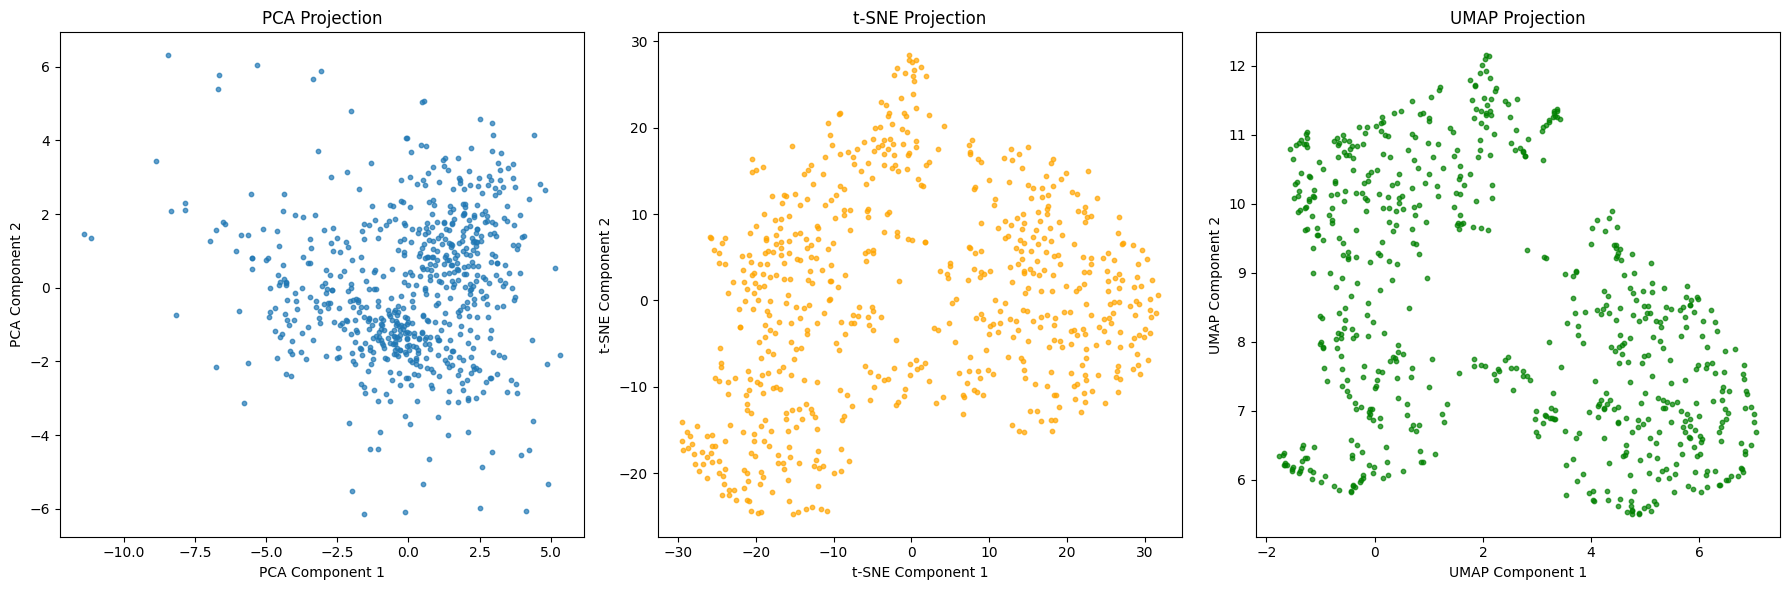

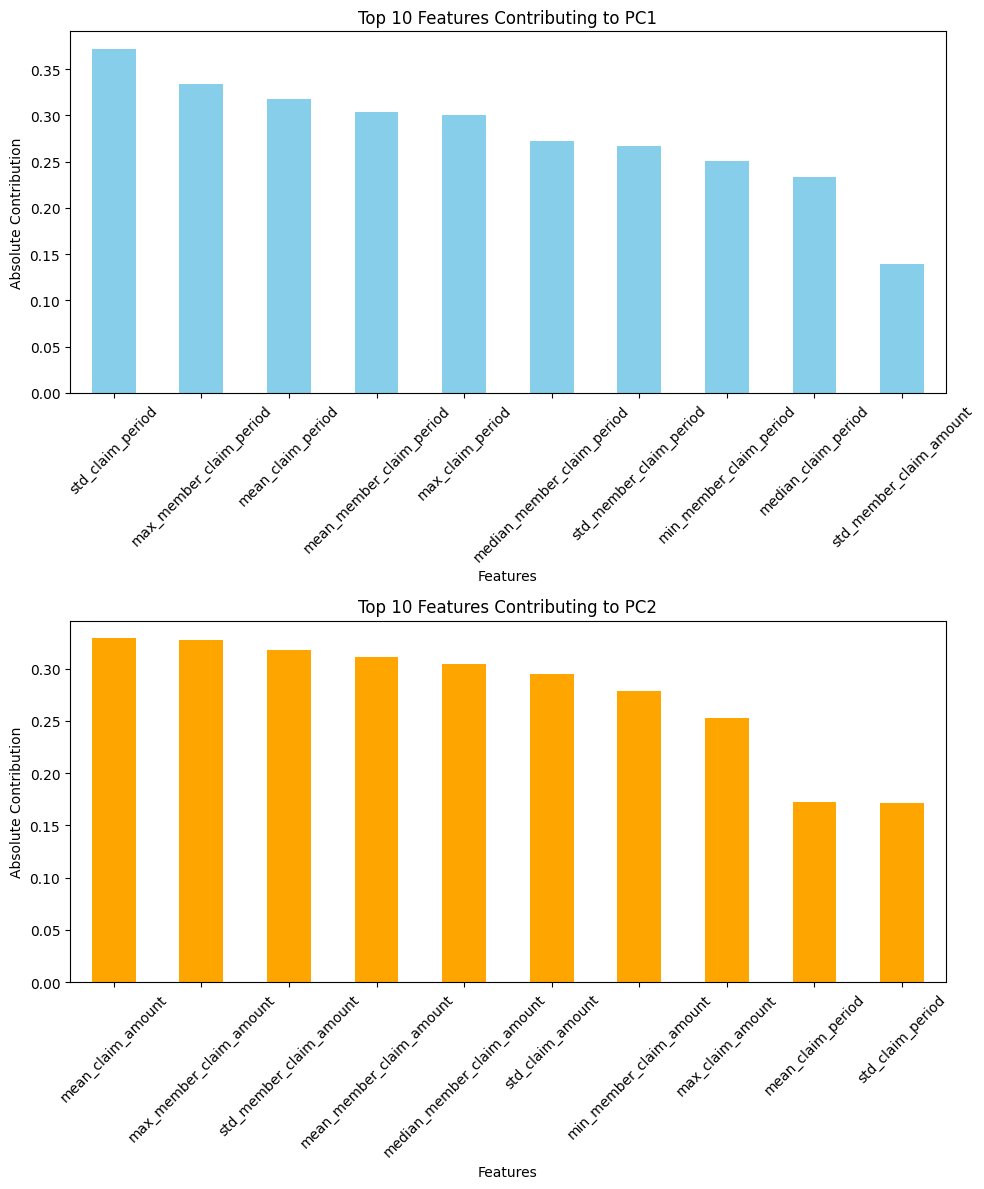

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(final_df)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(final_df)

# UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(final_df)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PCA scatter plot
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, s=10)
axes[0].set_title("PCA Projection")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")

# t-SNE scatter plot
axes[1].scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7, s=10, color='orange')
axes[1].set_title("t-SNE Projection")
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")

# UMAP scatter plot
axes[2].scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.7, s=10, color='green')
axes[2].set_title("UMAP Projection")
axes[2].set_xlabel("UMAP Component 1")
axes[2].set_ylabel("UMAP Component 2")

plt.tight_layout()
plt.show()

pca_components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

pca_axes_interpretation = pd.DataFrame(
    data=pca_components.T,  
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=final_df.columns
)

top_features_pc1 = pca_axes_interpretation['PC1'].abs().sort_values(ascending=False).head(10)
top_features_pc2 = pca_axes_interpretation['PC2'].abs().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

top_features_pc1.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title("Top 10 Features Contributing to PC1")
axes[0].set_ylabel("Absolute Contribution")
axes[0].set_xlabel("Features")
axes[0].tick_params(axis='x', rotation=45)

top_features_pc2.plot(kind='bar', color='orange', ax=axes[1])
axes[1].set_title("Top 10 Features Contributing to PC2")
axes[1].set_ylabel("Absolute Contribution")
axes[1].set_xlabel("Features")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [102]:
top_features_pc1.keys()

Index(['std_claim_period', 'max_member_claim_period', 'mean_claim_period', 'mean_member_claim_period', 'max_claim_period', 'median_member_claim_period', 'std_member_claim_period', 'min_member_claim_period', 'median_claim_period', 'std_member_claim_amount'], dtype='object')

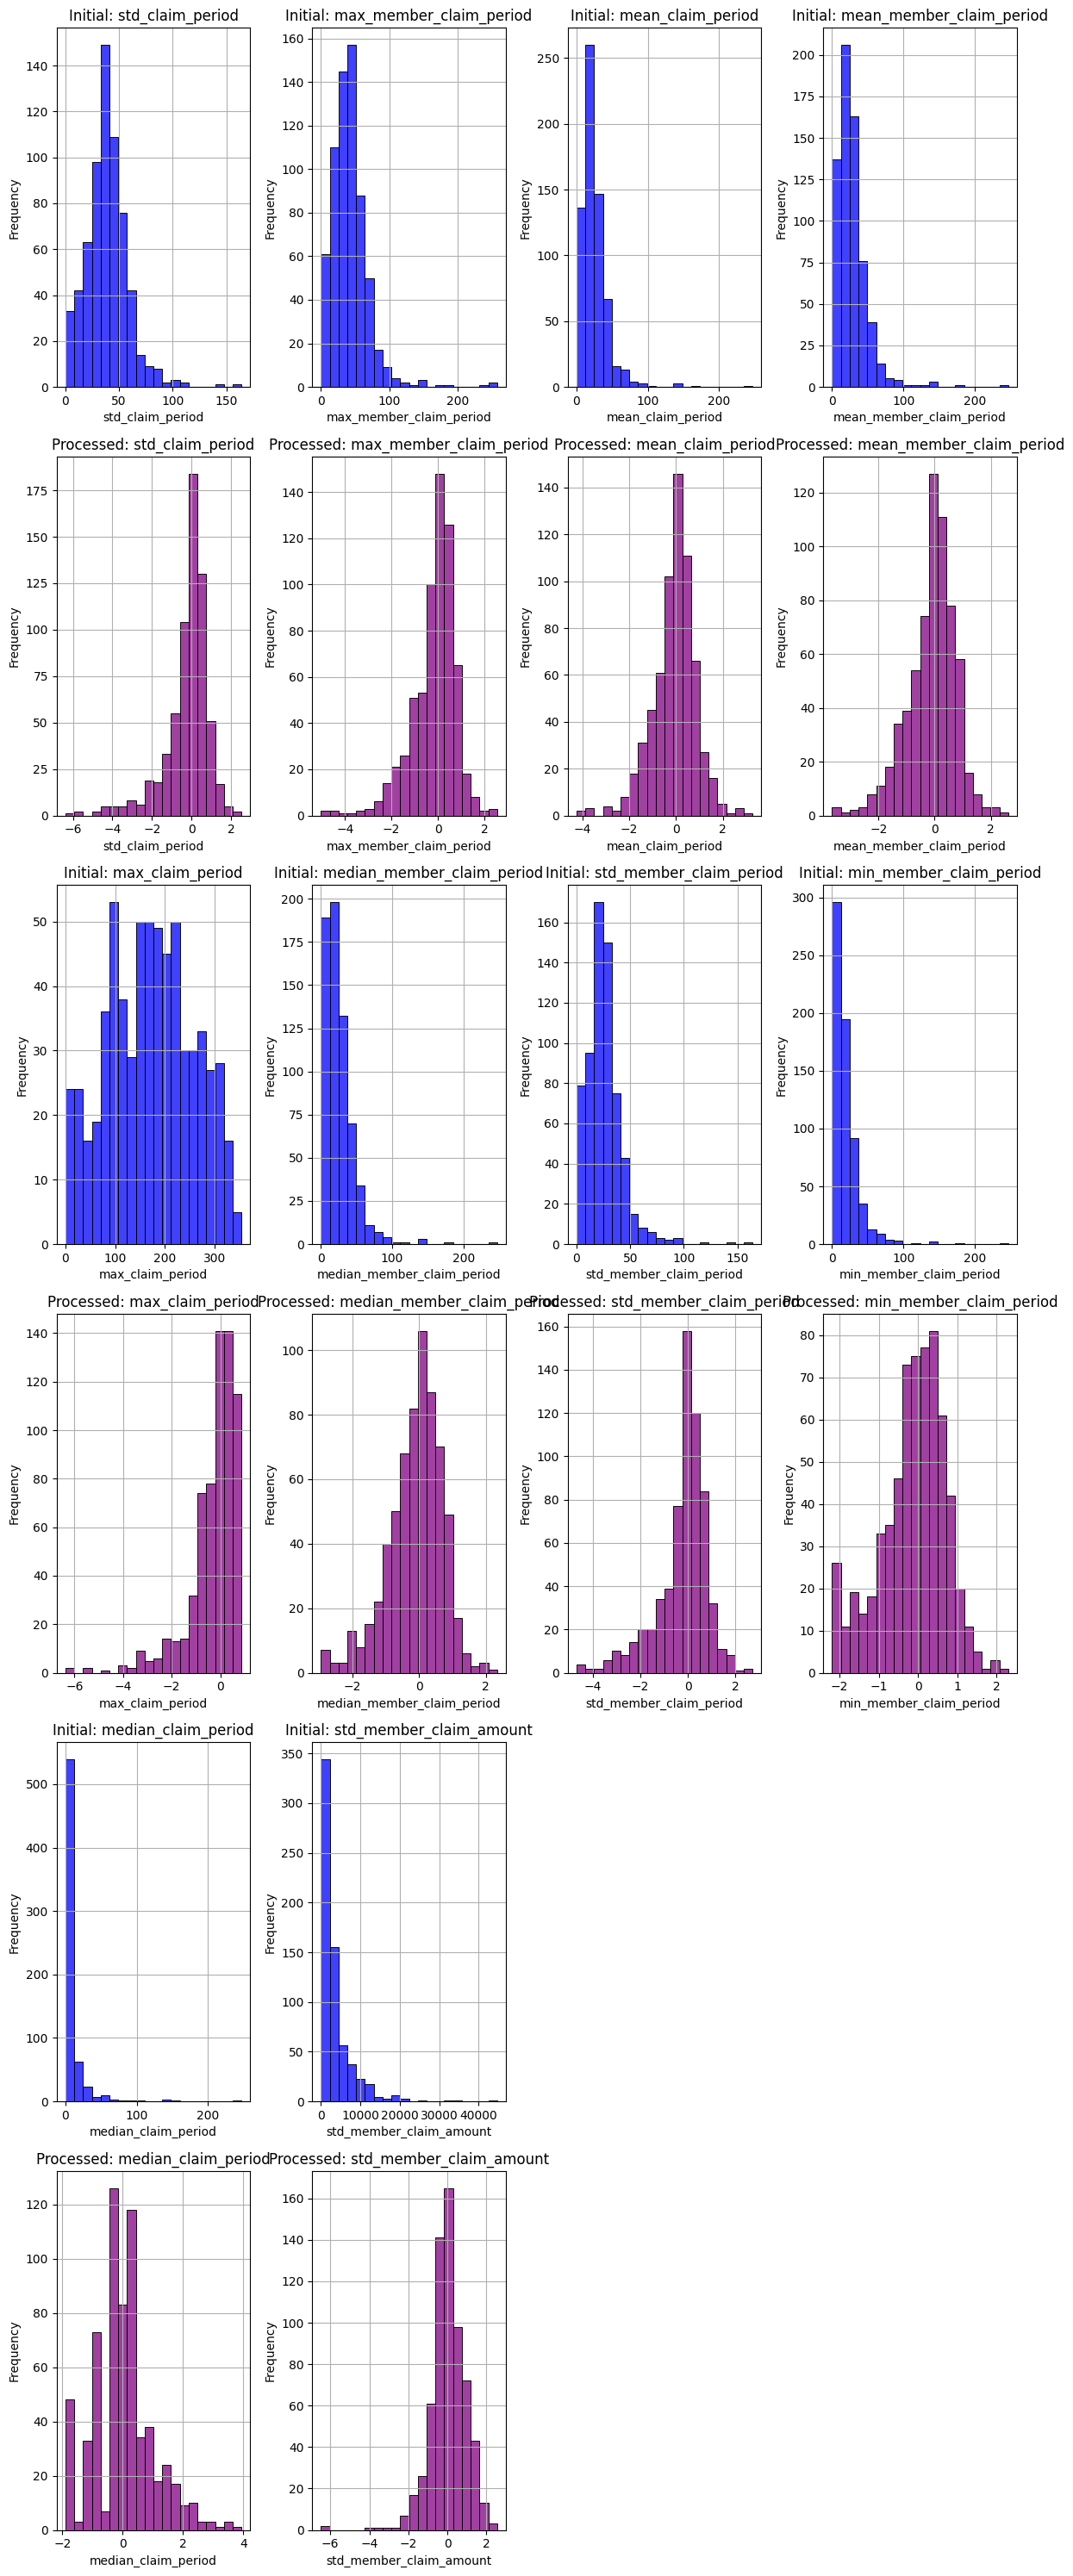

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_features(features, reverted_df, processed_df, bins=20, figsize=(12, 5)):
    """
    Plot multiple features from reverted and processed data in a dynamic grid layout.

    Parameters:
    - features: List of feature names to plot.
    - reverted_df: DataFrame containing reverted features.
    - processed_df: DataFrame containing processed features.
    - bins: Number of bins for the histogram.
    - figsize: Size of the figure (per subplot).
    """
    n_features = len(features)
    n_cols = 4  # Number of columns for the grid
    n_rows = math.ceil(n_features / n_cols)  # Calculate rows dynamically

    fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(figsize[0], figsize[1] * n_rows * 2))

    # Ensure axes is always 2D
    axes = axes.reshape(n_rows * 2, n_cols)

    for idx, feature_name in enumerate(features):
        row = (idx // n_cols) * 2
        col = idx % n_cols

        # Reverted Data Plot
        sns.histplot(reverted_df[feature_name], bins=bins, color="blue", ax=axes[row, col])
        axes[row, col].set_title(f"Initial: {feature_name}")
        axes[row, col].set_xlabel(feature_name)
        axes[row, col].set_ylabel("Frequency")
        axes[row, col].grid(True)

        # Processed Data Plot
        sns.histplot(processed_df[feature_name], bins=bins, color="purple", ax=axes[row + 1, col])
        axes[row + 1, col].set_title(f"Processed: {feature_name}")
        axes[row + 1, col].set_xlabel(feature_name)
        axes[row + 1, col].set_ylabel("Frequency")
        axes[row + 1, col].grid(True)

    # Remove unused subplots
    for i in range(n_features, n_rows * n_cols):
        fig.delaxes(axes[(i // n_cols) * 2, i % n_cols])  # For reverted plots
        fig.delaxes(axes[((i // n_cols) * 2) + 1, i % n_cols])  # For processed plots

    plt.tight_layout()
    plt.show()

#features_to_plot = ["mean_member_claim_period", "median_member_claim_period", "min_claim_period"]
plot_features(list(top_features_pc1.keys()), reverted_df, processed_df, bins=20, figsize=(12, 5))


In [ ]:
# patient features

In [26]:
all_cpt_descriptions = list(set(el for sublist in grouped_df.cpt_description.to_list() for el in sublist))
all_icd_descriptions = list(set(el for sublist in grouped_df.icddisease.to_list() for el in sublist))
all_benefit_descriptions = list(set(el for sublist in grouped_df.benefit_description.to_list() for el in sublist))

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

dataset_text = all_benefit_descriptions

random_indexes = np.random.randint(0, len(dataset_text), 2)
text1 = dataset_text[random_indexes[0]]
text2 = dataset_text[random_indexes[1]]
print(text1)
print(text2)
embedding_1 = get_embedding(text1, tokenizer, model).reshape(1,-1)
embedding_2 = get_embedding(text2, tokenizer, model).reshape(1,-1)

X_text = np.zeros((len(dataset_text),768))

for idx, text in tqdm(enumerate(dataset_text)) :
    X_text[idx,:] = get_embedding(text, tokenizer, model).reshape(1,-1)

cosine_similarity_score = cosine_similarity(X_text)
print(cosine_similarity_score[random_indexes[0], random_indexes[1]])

def top_k_values_and_indices(arr, k=10, largest=True):
    mask = ~np.eye(arr.shape[0], dtype=bool)  # Mask to exclude diagonal elements
    masked_indices = np.argwhere(mask)  # Get the row, col indices of non-diagonal elements
    masked_values = arr[mask]  # Flattened array without diagonal elements
    
    # Get top-k indices in the flattened masked_values
    flat_indices = np.argpartition(masked_values, -k if largest else k)[-k:] if largest else np.argpartition(masked_values, k)[:k]
    top_indices = masked_indices[flat_indices]  # Map back to original row, col indices
    top_values = masked_values[flat_indices]   # Get corresponding values
    
    # Sort the values and indices
    sorted_order = np.argsort(top_values)[::-1] if largest else np.argsort(top_values)
    sorted_values = top_values[sorted_order]
    sorted_indices = top_indices[sorted_order]
    
    return sorted_values, [tuple(idx) for idx in sorted_indices]


min_values, min_indices = top_k_values_and_indices(cosine_similarity_score, largest=False)
max_values, max_indices = top_k_values_and_indices(cosine_similarity_score, largest=True)

print("5 smallest values:", values)
print("Indices:", indices)

print("Minimal : \n ")
for indexe in min_indices : 
    print("Score", cosine_similarity_score[indexe[0],indexe[1]])
    print("text1 :", dataset_text[indexe[0]])
    print("text2 : ", dataset_text[indexe[1]])

print("Maximal : \n ")
for indexe in max_indices : 
    print("Score", cosine_similarity_score[indexe[0],indexe[1]])
    print("text1 :", dataset_text[indexe[0]])
    print("text2 : ", dataset_text[indexe[1]])


In [13]:
numerical_features = ['mean_member_claim_period',
 'median_member_claim_period',
 'min_member_claim_period',
 'max_member_claim_period',
 'std_member_claim_period',
 'mean_claim_period',
 'median_claim_period',
 'min_claim_period',
 'max_claim_period',
 'std_claim_period',
 'mean_member_claim_amount',
 'median_member_claim_amount',
 'min_member_claim_amount',
 'max_member_claim_amount',
 'std_member_claim_amount',
 'mean_claim_amount',
 'median_claim_amount',
 'min_claim_amount',
 'max_claim_amount',
 'std_claim_amount',
 'single_interaction_ratio',
 'num_members',
 'num_claims']



In [14]:
numerical_anomaly_injection_params = {
    'columns' : numerical_features, 
    'p' : 0.1, 
    'c' : 1, 
    'scale_factor' : 3, 
    'strategy' : "mixed", 
    'alpha' : 0.5
}
#categorical_anomaly_injection_params = {
#    'columns' : categorical_features, 
#    'p' : 0.1, 
#    'c' : 1, 
#    'strategy' : "mixed", 
#    'alpha' : 0.5
#} 
#

df_with_numerical_anomalies = inject_numerical_anomalies(final_df, **numerical_anomaly_injection_params)
#df_with_categorical_anomalies = inject_categorical_anomalies(final_df, **categorical_anomaly_injection_params)


In [15]:
df_with_numerical_anomalies

,one_hot_claim__finalstatus_infrequent_sklearn,one_hot_claim__claimtype_infrequent_sklearn,one_hot_claim__loastatus_infrequent_sklearn,one_hot_claim__roomtype_infrequent_sklearn,one_hot_claim__principalcode_principal,one_hot_claim__casetype_reimbursement,one_hot_claim__gender_m,one_hot_provider__providertype_clinic,one_hot_provider__providertype_hospital,one_hot_provider__providertype_infrequent_sklearn,one_hot_provider__providerlevel_level0,one_hot_provider__providerlevel_level1,one_hot_provider__providerlevel_level2,one_hot_provider__accredited_infrequent_sklearn,mean_member_claim_period,median_member_claim_period,min_member_claim_period,max_member_claim_period,std_member_claim_period,mean_claim_period,median_claim_period,min_claim_period,max_claim_period,std_claim_period,mean_member_claim_amount,median_member_claim_amount,min_member_claim_amount,max_member_claim_amount,std_member_claim_amount,mean_claim_amount,median_claim_amount,min_claim_amount,max_claim_amount,std_claim_amount,single_interaction_ratio,num_members,num_claims,hdbscan_cluster_from_semantics,synthetic_anomaly,anomaly_type
0,0.0,0.062780,0.008969,0.0,0.349776,0.067265,0.399103,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.124769,-0.080504,-0.185405,-0.094656,0.079513,-0.064445,-0.429308,0.0,0.027869,-0.038447,0.134638,0.005079,0.029332,0.501533,0.524022,0.321360,0.050260,-0.262126,0.966920,0.789321,-0.449752,0.563258,0.548708,1.0,False,NaN
1,0.0,0.000000,0.000000,0.0,0.472222,0.083333,0.333333,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.124695,0.244329,0.339322,-0.255670,0.137365,0.209892,0.000000,0.0,-0.833797,-0.132497,0.308787,0.309342,0.334307,0.189355,0.537356,0.474466,0.675916,0.763060,-0.215126,-0.003480,1.110301,-0.277891,-0.568451,1.0,False,NaN
2,0.0,0.008342,0.005214,0.0,0.662148,0.020855,0.344108,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.412900,-0.415572,-0.510820,-0.210853,-0.211600,-0.474252,-0.193043,0.0,0.728740,-0.456984,-0.603881,-0.739750,-0.645090,-0.370478,-0.393823,-0.617874,-0.583296,-0.231640,0.285726,-0.109757,-0.722677,1.375164,1.451557,1.0,False,NaN
3,0.0,0.007160,0.004773,0.0,0.625298,0.026253,0.436754,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.680374,-0.593849,-0.913887,-0.460248,-0.184329,-0.569375,-0.733907,0.0,0.270935,-0.409968,-0.442921,-0.527858,-0.465632,-0.335042,-0.328537,-0.548802,-0.583296,-0.440637,0.323048,-0.065129,-0.578037,0.911511,0.938692,1.0,False,NaN
4,0.0,0.175573,0.000000,0.0,0.694656,0.045802,0.580153,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.180179,1.071630,1.179376,1.032700,1.140953,0.996536,-0.429308,0.0,0.516334,1.141439,1.013815,0.995648,0.982742,0.931602,0.851399,1.081335,0.571845,0.456543,0.548513,0.721966,0.413834,0.404467,0.220617,1.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,0.0,0.058824,0.000000,0.0,0.960784,0.901961,0.274510,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-2.030891,1.738239,0.412385,-0.272565,1.045652,2.622864,1.262644,0.0,-1.095189,0.700724,-1.337011,-0.061649,0.130621,-0.938534,0.811463,-0.663648,1.910062,-0.967196,0.545325,0.478997,1.375780,1.918139,-0.357315,1.0,True,mixed
713,0.0,0.008475,0.025424,0.0,0.338983,0.000000,0.449153,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.145897,0.184201,-0.210287,0.285868,-2.956661,0.209892,4.397032,0.0,3.105344,4.302719,-0.518541,0.574489,-0.954737,-1.062039,-0.683528,-2.248831,-0.583296,-0.235453,-0.103011,-0.206290,2.676302,-0.610238,0.156295,1.0,True,mixed
714,0.0,0.013937,0.003484,0.0,0.686411,0.000000,0.219512,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.271096,2.921462,0.723090,2.973135,-0.388982,3.203037,-0.644902,0.0,3.155792,5.403706,-0.596244,-0.405048,-0.854138,-0.347739,1.167014,-1.472179,-0.583296,-0.917148,-0.292589,-0.563309,0.060404,2.398041,0.704621,1.0,True,mixed
715,0.0,0.004902,0.004902,0.0,0.607843,0.004902,0.382353,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.102196,-0.995733,2.980146,1.463743,0.583180,-0.779042,1.467814,0.0,4.431985,0.570753,2.810742,-0.387751,0.578409,-0.023806,0.044142,0.836430,0.367591,-0.

In [131]:
df_with_anomalies

,one_hot_claim__finalstatus_infrequent_sklearn,one_hot_claim__claimtype_infrequent_sklearn,one_hot_claim__loastatus_infrequent_sklearn,one_hot_claim__roomtype_infrequent_sklearn,one_hot_claim__principalcode_principal,one_hot_claim__casetype_reimbursement,one_hot_claim__gender_m,one_hot_provider__providertype_clinic,one_hot_provider__providertype_hospital,one_hot_provider__providertype_infrequent_sklearn,one_hot_provider__providerlevel_level0,one_hot_provider__providerlevel_level1,one_hot_provider__providerlevel_level2,one_hot_provider__accredited_infrequent_sklearn,mean_member_claim_period,median_member_claim_period,min_member_claim_period,max_member_claim_period,std_member_claim_period,mean_claim_period,median_claim_period,min_claim_period,max_claim_period,std_claim_period,mean_member_claim_amount,median_member_claim_amount,min_member_claim_amount,max_member_claim_amount,std_member_claim_amount,mean_claim_amount,median_claim_amount,min_claim_amount,max_claim_amount,std_claim_amount,single_interaction_ratio,num_members,num_claims,hdbscan_cluster_from_semantics,synthetic_anomaly,anomaly_type
0,0.000000,0.062780,0.008969,0.0,0.349776,0.067265,0.399103,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.124769,-0.080504,-0.185405,-0.094656,0.079513,-0.064445,-0.429308,0.0,0.027869,-0.038447,0.134638,0.005079,0.029332,0.501533,0.524022,0.321360,0.050260,-0.262126,0.966920,0.789321,-0.449752,0.563258,0.548708,1.0,False,NaN
1,0.000000,0.000000,0.000000,0.0,0.472222,0.083333,0.333333,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.124695,0.244329,0.339322,-0.255670,0.137365,0.209892,0.000000,0.0,-0.833797,-0.132497,0.308787,0.309342,0.334307,0.189355,0.537356,0.474466,0.675916,0.763060,-0.215126,-0.003480,1.110301,-0.277891,-0.568451,1.0,False,NaN
2,0.000000,0.008342,0.005214,0.0,0.662148,0.020855,0.344108,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.412900,-0.415572,-0.510820,-0.210853,-0.211600,-0.474252,-0.193043,0.0,0.728740,-0.456984,-0.603881,-0.739750,-0.645090,-0.370478,-0.393823,-0.617874,-0.583296,-0.231640,0.285726,-0.109757,-0.722677,1.375164,1.451557,1.0,False,NaN
3,0.000000,0.007160,0.004773,0.0,0.625298,0.026253,0.436754,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.680374,-0.593849,-0.913887,-0.460248,-0.184329,-0.569375,-0.733907,0.0,0.270935,-0.409968,-0.442921,-0.527858,-0.465632,-0.335042,-0.328537,-0.548802,-0.583296,-0.440637,0.323048,-0.065129,-0.578037,0.911511,0.938692,1.0,False,NaN
4,0.000000,0.175573,0.000000,0.0,0.694656,0.045802,0.580153,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.180179,1.071630,1.179376,1.032700,1.140953,0.996536,-0.429308,0.0,0.516334,1.141439,1.013815,0.995648,0.982742,0.931602,0.851399,1.081335,0.571845,0.456543,0.548513,0.721966,0.413834,0.404467,0.220617,1.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,0.000000,0.118644,0.000000,0.0,0.703390,0.033898,0.372881,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.296553,0.170604,0.107614,0.519104,0.596031,0.463614,0.429308,0.0,0.213030,0.350611,-0.160624,-0.188882,-0.098947,-0.177986,-0.064842,-0.146940,-0.583296,0.110652,-0.413879,-0.174777,0.266470,0.272708,0.156295,1.0,True,switching
713,0.000000,0.014085,0.000000,0.0,0.661972,0.000000,0.098592,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.493007,-0.484338,-0.405296,-0.339185,0.056670,-0.286978,-1.163215,0.0,0.516334,0.370728,-0.236137,-0.293328,-0.350756,-0.367593,0.117287,0.841732,-0.583296,-0.440637,0.794132,0.064546,-0.359602,-0.168459,-0.155426,1.0,True,switching
714,0.003846,0.042308,0.000000,0.0,0.515385,0.034615,0.288462,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.082665,0.092209,0.081015,0.104803,0.102622,0.141380,0.304599,0.0,0.242322,0.070323,0.586174,0.446455,0.477752,0.774475,-0.356227,0.604596,-0.187438,-0.440637,0.979698,-0.063440,-0.452302,0.663038,0.643550,1.0,True,switching
715,0.000000,0.013514,0.000000,0.0,0.810811,0.000000,0.405405,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.006268,0.058964,0.277827,-0.066941,-0.849427,-0.178075,-0.429308,0.0,0.152271,0.249720,-0.243242,-0.3